In [1]:
from brian2 import *
%matplotlib inline
import os,random


In [5]:
sim_time = 400 * ms
time_step = 0.001 * ms
defaultclock.dt = time_step
num_neurons = 34 * 34
n_of_m = 100
file_loc = "D://Download/N-MNIST/Train/"
time_dur = []
spike_digits = []
tot_spike_index = []
tot_spike_time = []
iterations = 3
accu_time = 0


for z in range(iterations):
    digit = random.choice(os.listdir(file_loc))
    Bytes = numpy.fromfile(file_loc+'/'+digit+'/'+random.choice(os.listdir(file_loc+'/'+digit)), dtype = "uint8")
    spike_digits.append(int(digit))
    Bits = numpy.unpackbits(Bytes)
    Bits = Bits.reshape(int(len(Bits)/40), 40)

    prev_ts = 0
    prev_ind = 0
    counter_n = 0
    spike_time = []
    spike_index = []

    for q in Bits:
            if(counter_n<n_of_m):
                counter_n += 1
            else:
                break
            q  = np.flip(q)
            tmp = q[:23]
            time_stamp = tmp.dot(1 << np.arange(tmp.shape[-1])) 
            tmp =  q[24:32]
            y = tmp.dot(1 << np.arange(tmp.shape[-1]))
            tmp = q[32:]
            x = tmp.dot(1 << np.arange(tmp.shape[-1]))
            ind = (y*34) + x
            if(prev_ts!=time_stamp or prev_ind!=ind):
                spike_time.append((int)(accu_time+time_stamp))
                spike_index.append(ind)
            prev_ts = time_stamp
            prev_ind = ind
    j= []
    accu_time += prev_ts + 10000
    for a in spike_time:
        j.append(a+prev_ts + 10000)   
    time_dur.append(prev_ts)
    accu_time += prev_ts + 10000
    tot_spike_time = tot_spike_time + spike_time + j
    tot_spike_index = tot_spike_index + spike_index + spike_index
    
tot_spike_time *= time_step

In [6]:
vt = -54*mV
vr = -60*mV
El = -74*mV

tau_pre = 30*ms
taue = 30*ms
taupre = 15*ms
taupost = taupre


gmax = 14
dApre = 7
dApost = -dApre * taupre / taupost * 1.05



eqs_stdp = '''
dv/dt = ( El - v) / tau_pre : volt (unless refractory)
rates : Hz
'''

SG = SpikeGeneratorGroup(num_neurons, tot_spike_index, tot_spike_time)
add = NeuronGroup(10000, eqs_stdp,reset='v=vr',threshold='v>vt', refractory=time_step*2 ,method='euler')
G2 = NeuronGroup(10, eqs_stdp,reset='v=vr',threshold='rand()<rates*dt or v>vt', refractory=time_step*5, method='euler')

add.v = vr
G2.v = vr

Sy = Synapses(SG, add,
             'w:volt',
             on_pre='v_post += w',
             )
Sy.connect(p=0.0002)
Sy.w = 11 * mV

Sy2 = Synapses(add, G2,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''v += w*mV
                    Apre += dApre
                    w = clip(w + Apost, -gmax, gmax)''',
             on_post='''
                     Apost += dApost
                     w = clip(w + Apre, -gmax, gmax)''',
             )
Sy3 = Synapses(G2, add,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''
                    Apre += dApre
                    w = clip(w + Apost, -gmax, gmax)''',
             on_post='''
                     Apost += dApost
                     w = clip(w + Apre, -gmax, gmax)''',
             )


Sy2.connect()
Sy3.connect()
S1 = SpikeMonitor(SG)
S2 = SpikeMonitor(G2)
S3 = SpikeMonitor(add)
net = Network(collect())

In [7]:
for z in range(iterations):    
    G2[spike_digits[z]].rates = 300*Hz
    net.run((time_dur[z]//1000+10) * ms, report = 'text')
    G2.rates = 0 * Hz
    net.run((time_dur[z]//1000+10) * ms, report = 'text')

Starting simulation at t=0. s for a duration of 26. ms
26. ms (100%) simulated in 3s
Starting simulation at t=26. ms for a duration of 26. ms
26. ms (100%) simulated in 3s
Starting simulation at t=52. ms for a duration of 29. ms
29. ms (100%) simulated in 3s
Starting simulation at t=81. ms for a duration of 29. ms
29. ms (100%) simulated in 4s
Starting simulation at t=110. ms for a duration of 30. ms
30. ms (100%) simulated in 4s
Starting simulation at t=140. ms for a duration of 30. ms
30. ms (100%) simulated in 3s


In [8]:
c = 0
d = 10+time_dur[c]//1000
predictions = []
spike_list = [0,0,0,0,0,0,0,0,0,0]
for z in range(len(S2.t/ms)):
    if(S2.t[z]/ms>d and S2.t[z]/ms<d+10+time_dur[c]//1000):
        spike_list[S2.i[z]]+=1
    elif(S2.t[z]/ms>d+10+time_dur[c]//1000):
        d += 10+time_dur[c]//1000
        if(c<len(time_dur)-1):
            c += 1
        d += 10+time_dur[c]//1000
        predictions.append(np.argmax(spike_list))
        spike_list = [0,0,0,0,0,0,0,0,0,0]
predictions.append(np.argmax(spike_list))

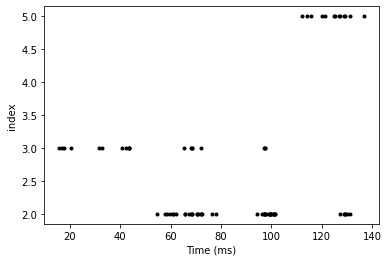

In [9]:
plot(S2.t/ms, S2.i, '.k')
xlabel('Time (ms)')
ylabel('index');

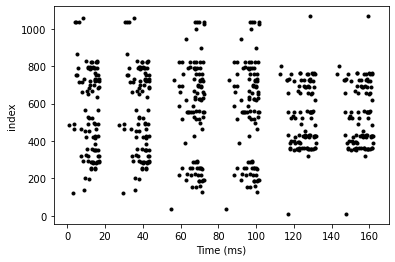

In [10]:
plot(S1.t/ms, S1.i, '.k')
xlabel('Time (ms)')
ylabel('index');

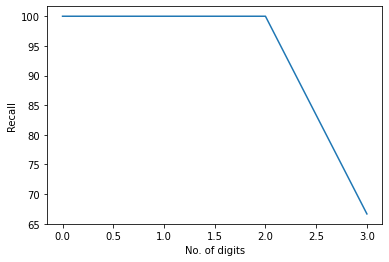

In [11]:
tot_dig = 0
corr = 0
recall = [100]
for z in range(len(spike_digits)):
    if(predictions[z]==spike_digits[z]):
        corr += 1
    tot_dig += 1
    recall.append((100*corr)/tot_dig)

plot(recall)
xlabel('No. of digits')
ylabel('Recall');  

In [12]:
spike_digits

[3, 2, 5]

In [13]:
predictions

[3, 2, 0]

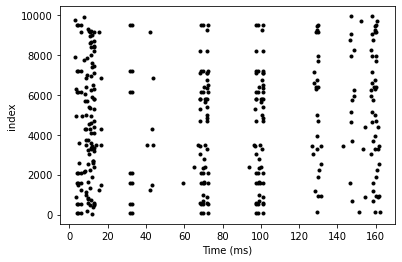

In [14]:
plot(S3.t/ms, S3.i, '.k')
xlabel('Time (ms)')
ylabel('index');

In [15]:
len(S3.t)

353